# 🧬 CAFA-6 Protein Function Prediction - Exploratory Data Analysis

## Overview
This notebook provides a comprehensive EDA for the CAFA-6 (Critical Assessment of Functional Annotation) competition dataset.

**Objective:** Predict Gene Ontology (GO) terms for proteins based on their amino acid sequences.

### Dataset Files:
- `train_sequences.fasta` - Protein sequences for training
- `train_terms.tsv` - GO term annotations (labels)
- `train_taxonomy.tsv` - Species taxonomy information
- `go-basic.obo` - Gene Ontology graph structure
- `testsuperset.fasta` - Test protein sequences
- `IA.tsv` - Information Accretion weights for evaluation

### Gene Ontology Subontologies:
- **MFO (Molecular Function)** - What the protein does at molecular level
- **BPO (Biological Process)** - Which biological processes it participates in
- **CCO (Cellular Component)** - Where in the cell it is located

## 1. Setup and Imports

In [41]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# For parsing biological data
import obonet
import networkx as nx

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Data paths
DATA_DIR = "../../data"
TRAIN_DIR = os.path.join(DATA_DIR, "Train")
TEST_DIR = os.path.join(DATA_DIR, "Test")

print("Libraries imported successfully!")
print(f"Data directory: {os.path.abspath(DATA_DIR)}")

Libraries imported successfully!
Data directory: e:\Project\CAFA-6-Protein-Function-Prediction-Kaggle\data


## 2. Helper Functions for Data Loading

In [42]:
def parse_fasta(fasta_file):
    """
    Parse FASTA file and return a dictionary of protein IDs to sequences.
    Also extracts metadata from headers.
    """
    sequences = {}
    current_id = None
    current_seq = []
    
    with open(fasta_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                # Save previous sequence
                if current_id is not None:
                    sequences[current_id] = {
                        'sequence': ''.join(current_seq),
                        'header': current_header
                    }
                
                # Parse new header
                current_header = line[1:]  # Remove '>'
                # Extract UniProt ID (format: sp|P9WHI7|RECN_MYCT or just ID|taxon)
                parts = current_header.split('|')
                if len(parts) >= 2:
                    current_id = parts[1] if parts[0] in ['sp', 'tr'] else parts[0]
                else:
                    current_id = parts[0].split()[0]
                current_seq = []
            else:
                current_seq.append(line)
        
        # Don't forget the last sequence
        if current_id is not None:
            sequences[current_id] = {
                'sequence': ''.join(current_seq),
                'header': current_header
            }
    
    return sequences


def load_train_terms(filepath):
    """Load training terms/labels file."""
    return pd.read_csv(filepath, sep='\t', names=['protein_id', 'go_term', 'ontology'])


def load_taxonomy(filepath):
    """Load taxonomy file."""
    return pd.read_csv(filepath, sep='\t', names=['protein_id', 'taxon_id'])


def load_ia_weights(filepath):
    """Load Information Accretion weights."""
    return pd.read_csv(filepath, sep='\t', names=['go_term', 'ia_weight'])


def get_sequence_stats(sequences):
    """Calculate statistics for protein sequences."""
    lengths = [len(seq['sequence']) for seq in sequences.values()]
    return {
        'count': len(lengths),
        'min': min(lengths),
        'max': max(lengths),
        'mean': np.mean(lengths),
        'median': np.median(lengths),
        'std': np.std(lengths)
    }

print("Helper functions defined!")

Helper functions defined!


## 3. Load All Datasets

In [43]:
print("Loading datasets...")

# Load training sequences
train_sequences = parse_fasta(os.path.join(TRAIN_DIR, "train_sequences.fasta"))
print(f"Loaded {len(train_sequences):,} training sequences")

# Load test sequences
test_sequences = parse_fasta(os.path.join(TEST_DIR, "testsuperset.fasta"))
print(f"Loaded {len(test_sequences):,} test sequences")
# Load training terms (labels)
train_terms = load_train_terms(os.path.join(TRAIN_DIR, "train_terms.tsv"))
print(f"Loaded {len(train_terms):,} training annotations")

# Load taxonomy
train_taxonomy = load_taxonomy(os.path.join(TRAIN_DIR, "train_taxonomy.tsv"))
print(f"Loaded taxonomy for {len(train_taxonomy):,} proteins")
# Load Information Accretion weights
ia_weights = load_ia_weights(os.path.join(DATA_DIR, "IA.tsv"))
print(f"Loaded IA weights for {len(ia_weights):,} GO terms")

# Load Gene Ontology graph
go_graph = obonet.read_obo(os.path.join(TRAIN_DIR, "go-basic.obo"))
print(f"Loaded GO graph with {go_graph.number_of_nodes():,} nodes and {go_graph.number_of_edges():,} edges")
# Load test taxon list
test_taxon = pd.read_csv(os.path.join(TEST_DIR, "testsuperset-taxon-list.tsv"), sep='\t', header=None, names=['taxon_id'])
print(f"Loaded {len(test_taxon):,} unique taxons in test set")

Loading datasets...
Loaded 82,404 training sequences
Loaded 224,309 test sequences
Loaded 537,028 training annotations
Loaded taxonomy for 82,404 proteins
Loaded IA weights for 40,122 GO terms
Loaded GO graph with 40,122 nodes and 77,229 edges
Loaded 8,454 unique taxons in test set


## 4. Dataset Overview Summary

In [44]:
# Create overview summary
print("=" * 70)
print("📊 CAFA-6 DATASET OVERVIEW")
print("=" * 70)

# Training data summary
train_stats = get_sequence_stats(train_sequences)
test_stats = get_sequence_stats(test_sequences)

summary_data = {
    'Metric': [
        'Number of Proteins',
        'Number of GO Terms (unique labels)',
        'Total Annotations',
        'Average Annotations per Protein',
        'Average Sequence Length',
        'Min Sequence Length',
        'Max Sequence Length'
    ],
    'Training Set': [
        f"{len(train_sequences):,}",
        f"{train_terms['go_term'].nunique():,}",
        f"{len(train_terms):,}",
        f"{len(train_terms) / len(train_sequences):.2f}",
        f"{train_stats['mean']:.1f}",
        f"{train_stats['min']:,}",
        f"{train_stats['max']:,}"
    ],
    'Test Superset': [
        f"{len(test_sequences):,}",
        "Unknown (to predict)",
        "Unknown",
        "Unknown",
        f"{test_stats['mean']:.1f}",
        f"{test_stats['min']:,}",
        f"{test_stats['max']:,}"
    ]
}

summary_df = pd.DataFrame(summary_data)
display(summary_df)

print("\n" + "=" * 70)
print("📈 ONTOLOGY DISTRIBUTION")
print("=" * 70)
ontology_counts = train_terms['ontology'].value_counts()
ontology_names = {'BPO': 'Biological Process', 'CCO': 'Cellular Component', 'MFO': 'Molecular Function'}
for ont, count in ontology_counts.items():
    print(f"  {ont} ({ontology_names.get(ont, ont)}): {count:,} annotations ({100*count/len(train_terms):.1f}%)")

📊 CAFA-6 DATASET OVERVIEW


,Metric,Training Set,Test Superset
0,Number of Proteins,"82,404","224,309"
1,Number of GO Terms (unique labels),"26,126",Unknown (to predict)
2,Total Annotations,"537,028",Unknown
3,Average Annotations per Protein,6.52,Unknown
4,Average Sequence Length,525.8,429.2
5,Min Sequence Length,3,2
6,Max Sequence Length,"35,213","35,213"



📈 ONTOLOGY DISTRIBUTION
  P (P): 250,805 annotations (46.7%)
  C (C): 157,770 annotations (29.4%)
  F (F): 128,452 annotations (23.9%)
  aspect (aspect): 1 annotations (0.0%)


In [45]:
# Reload with correct handling - file has header
train_terms = pd.read_csv(os.path.join(TRAIN_DIR, "train_terms.tsv"), sep='\t')
train_terms.columns = ['protein_id', 'go_term', 'ontology']
print(f"✅ Reloaded {len(train_terms):,} training annotations")
print("\nFirst few rows:")
print(train_terms.head(10))
print("\nUnique ontology values:", train_terms['ontology'].unique())

# Map ontology codes to full names
ontology_map = {'P': 'BPO', 'C': 'CCO', 'F': 'MFO'}
train_terms['ontology'] = train_terms['ontology'].map(ontology_map)
print("\nMapped ontology values:", train_terms['ontology'].unique())

✅ Reloaded 537,027 training annotations

First few rows:
  protein_id     go_term ontology
0     Q5W0B1  GO:0000785        C
1     Q5W0B1  GO:0004842        F
2     Q5W0B1  GO:0051865        P
3     Q5W0B1  GO:0006275        P
4     Q5W0B1  GO:0006513        P
5     Q5W0B1  GO:0003682        F
6     Q5W0B1  GO:0005515        F
7     Q3EC77  GO:0000138        C
8     Q3EC77  GO:0005794        C
9     Q8IZR5  GO:0005515        F

Unique ontology values: ['C' 'F' 'P']

Mapped ontology values: ['CCO' 'MFO' 'BPO']


## 5. Protein Sequence Analysis

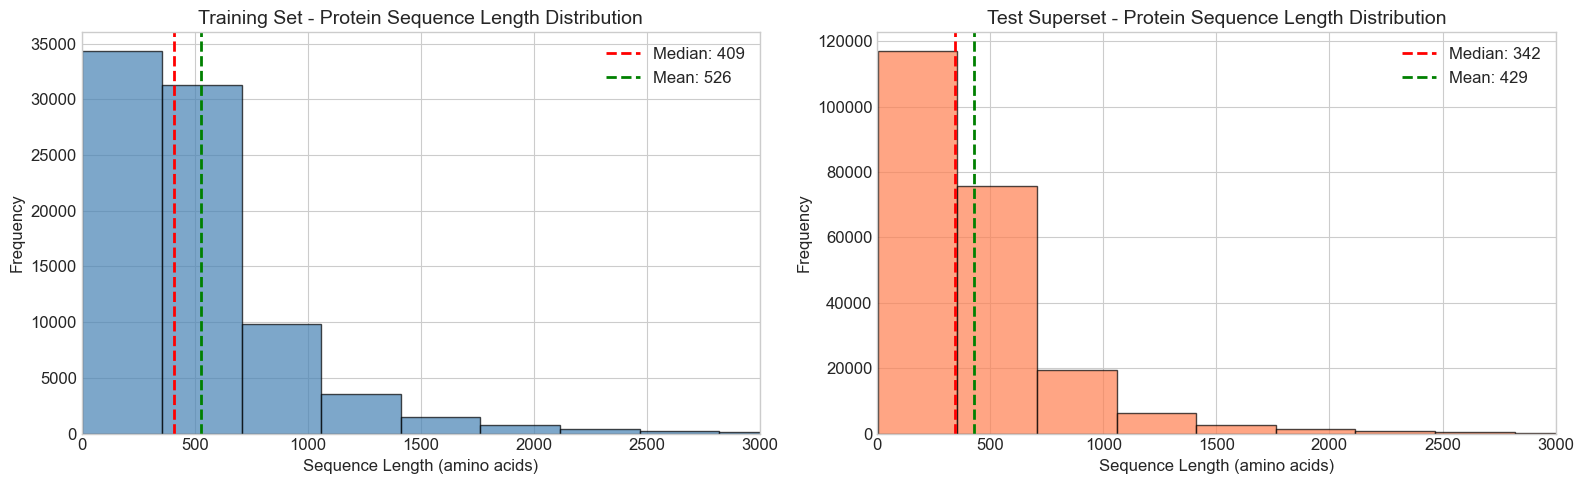


📊 Sequence Length Statistics:
--------------------------------------------------
Metric                        Training         Test
--------------------------------------------------
Count                           82,404      224,309
Mean                             525.8        429.2
Median                           409.0        342.0
Std                              521.6        442.1
Min                                  3            2
Max                             35,213       35,213


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Đảm bảo thư mục tồn tại
os.makedirs('../../figures', exist_ok=True)

# Calculate sequence lengths (Giữ nguyên logic tính toán của bạn)
# Giả sử biến train_sequences và test_sequences đã có sẵn trong môi trường chạy
train_lengths = [len(seq['sequence']) for seq in train_sequences.values()]
test_lengths = [len(seq['sequence']) for seq in test_sequences.values()]

# --- 1. VẼ VÀ LƯU ĐỒ THỊ TẬP TRAINING ---
print("🎨 Đang vẽ biểu đồ độ dài chuỗi tập Training...")
plt.figure(figsize=(8, 6))  # Tạo figure mới

plt.hist(train_lengths, bins=100, color='steelblue', alpha=0.7, edgecolor='black')
plt.axvline(np.median(train_lengths), color='red', linestyle='--', linewidth=2, label=f'Median: {np.median(train_lengths):.0f}')
plt.axvline(np.mean(train_lengths), color='green', linestyle='--', linewidth=2, label=f'Mean: {np.mean(train_lengths):.0f}')

plt.xlabel('Sequence Length (amino acids)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Training Set - Protein Sequence Length Distribution', fontsize=14)
plt.xlim(0, 3000)
plt.legend()

plt.tight_layout()
save_path_train = '../../figures/sequence_length_dist_train.png'
plt.savefig(save_path_train, dpi=150, bbox_inches='tight')
plt.show()
plt.close() # Đóng figure
print(f"✅ Đã lưu: {save_path_train}")


# --- 2. VẼ VÀ LƯU ĐỒ THỊ TẬP TEST ---
print("🎨 Đang vẽ biểu đồ độ dài chuỗi tập Test...")
plt.figure(figsize=(8, 6))  # Tạo figure mới

plt.hist(test_lengths, bins=100, color='coral', alpha=0.7, edgecolor='black')
plt.axvline(np.median(test_lengths), color='red', linestyle='--', linewidth=2, label=f'Median: {np.median(test_lengths):.0f}')
plt.axvline(np.mean(test_lengths), color='green', linestyle='--', linewidth=2, label=f'Mean: {np.mean(test_lengths):.0f}')

plt.xlabel('Sequence Length (amino acids)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Test Superset - Protein Sequence Length Distribution', fontsize=14)
plt.xlim(0, 3000)
plt.legend()

plt.tight_layout()
save_path_test = '../../figures/sequence_length_dist_test.png'
plt.savefig(save_path_test, dpi=150, bbox_inches='tight')
plt.show()
plt.close() # Đóng figure
print(f"✅ Đã lưu: {save_path_test}")


# --- 3. IN THỐNG KÊ (Giữ nguyên) ---
print("\n📊 Sequence Length Statistics:")
print("-" * 50)
print(f"{'Metric':<25} {'Training':>12} {'Test':>12}")
print("-" * 50)
print(f"{'Count':<25} {len(train_lengths):>12,} {len(test_lengths):>12,}")
print(f"{'Mean':<25} {np.mean(train_lengths):>12.1f} {np.mean(test_lengths):>12.1f}")
print(f"{'Median':<25} {np.median(train_lengths):>12.1f} {np.median(test_lengths):>12.1f}")
print(f"{'Std':<25} {np.std(train_lengths):>12.1f} {np.std(test_lengths):>12.1f}")
print(f"{'Min':<25} {np.min(train_lengths):>12} {np.min(test_lengths):>12}")
print(f"{'Max':<25} {np.max(train_lengths):>12,} {np.max(test_lengths):>12,}")

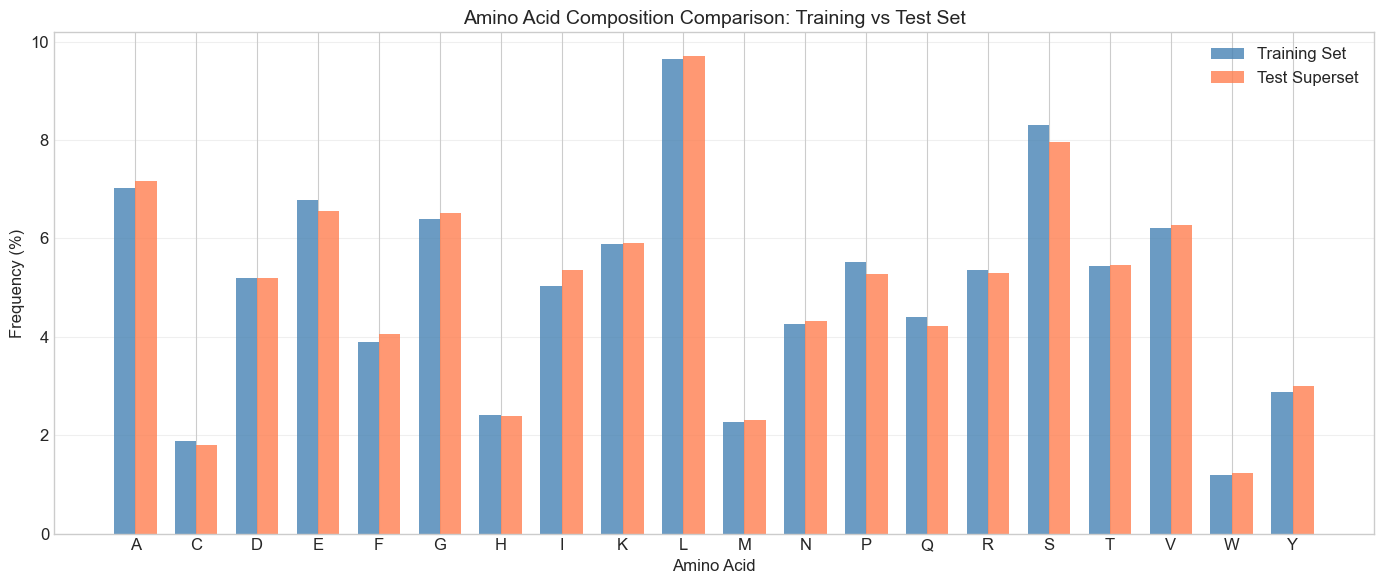


🔬 Unusual Characters in Sequences:
Training set unusual characters: {'X', 'B', 'U'}
Test set unusual characters: {'X', 'B', 'U', 'Z'}


In [47]:
# Amino acid composition analysis
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'

# Count amino acids in training set
train_aa_counts = Counter()
for seq_data in train_sequences.values():
    train_aa_counts.update(seq_data['sequence'])

# Count amino acids in test set
test_aa_counts = Counter()
for seq_data in test_sequences.values():
    test_aa_counts.update(seq_data['sequence'])

# Normalize to percentages
total_train = sum([train_aa_counts.get(aa, 0) for aa in amino_acids])
total_test = sum([test_aa_counts.get(aa, 0) for aa in amino_acids])

train_aa_freq = {aa: 100 * train_aa_counts.get(aa, 0) / total_train for aa in amino_acids}
test_aa_freq = {aa: 100 * test_aa_counts.get(aa, 0) / total_test for aa in amino_acids}

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(amino_acids))
width = 0.35

bars1 = ax.bar(x - width/2, [train_aa_freq[aa] for aa in amino_acids], width, label='Training Set', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, [test_aa_freq[aa] for aa in amino_acids], width, label='Test Superset', color='coral', alpha=0.8)

ax.set_xlabel('Amino Acid', fontsize=12)
ax.set_ylabel('Frequency (%)', fontsize=12)
ax.set_title('Amino Acid Composition Comparison: Training vs Test Set', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(list(amino_acids))
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../../figures/amino_acid_composition.png', dpi=150, bbox_inches='tight')
plt.show()

# Check for unusual amino acids
print("\n🔬 Unusual Characters in Sequences:")
unusual_train = set(train_aa_counts.keys()) - set(amino_acids)
unusual_test = set(test_aa_counts.keys()) - set(amino_acids)
print(f"Training set unusual characters: {unusual_train}")
print(f"Test set unusual characters: {unusual_test}")

## 6. Gene Ontology (GO) Terms Analysis

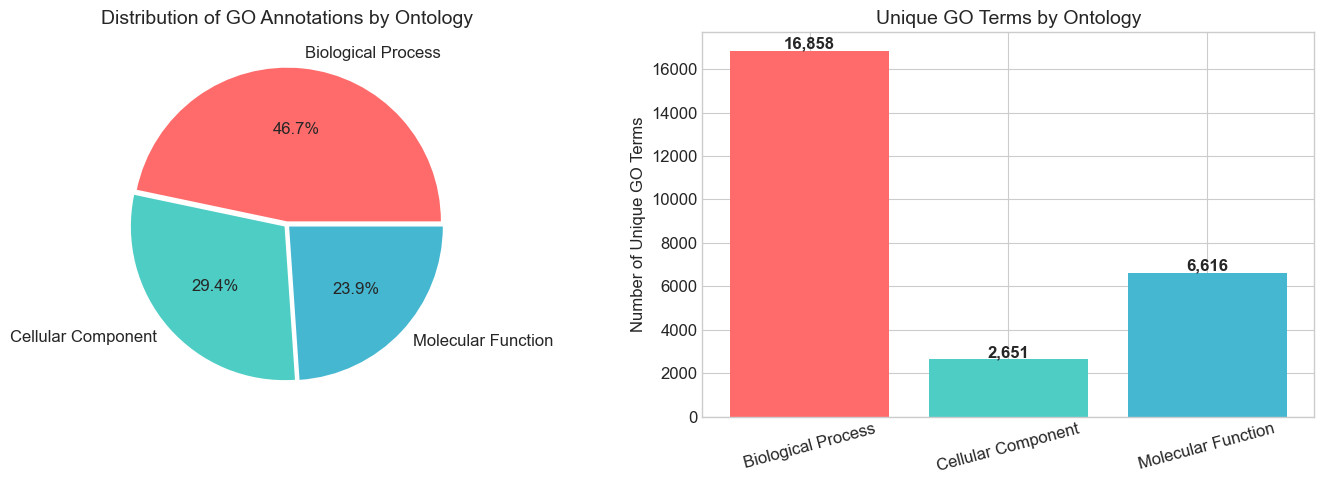


📊 Ontology Summary:
------------------------------------------------------------
Ontology                   Annotations    Unique Terms
------------------------------------------------------------
Biological Process             250,805          16,858
Cellular Component             157,770           2,651
Molecular Function             128,452           6,616


In [48]:
# Ontology distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart for annotations
ontology_counts = train_terms['ontology'].value_counts()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
ontology_names = {'BPO': 'Biological Process', 'CCO': 'Cellular Component', 'MFO': 'Molecular Function'}

axes[0].pie(ontology_counts.values, labels=[ontology_names[x] for x in ontology_counts.index], 
            autopct='%1.1f%%', colors=colors, explode=[0.02, 0.02, 0.02])
axes[0].set_title('Distribution of GO Annotations by Ontology', fontsize=14)

# Count unique GO terms per ontology
go_terms_per_ontology = train_terms.groupby('ontology')['go_term'].nunique()
axes[1].bar(range(len(go_terms_per_ontology)), go_terms_per_ontology.values, color=colors)
axes[1].set_xticks(range(len(go_terms_per_ontology)))
axes[1].set_xticklabels([ontology_names[x] for x in go_terms_per_ontology.index], rotation=15)
axes[1].set_ylabel('Number of Unique GO Terms', fontsize=12)
axes[1].set_title('Unique GO Terms by Ontology', fontsize=14)

for i, v in enumerate(go_terms_per_ontology.values):
    axes[1].text(i, v + 100, f'{v:,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../../figures/ontology_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Ontology Summary:")
print("-" * 60)
print(f"{'Ontology':<25} {'Annotations':>12} {'Unique Terms':>15}")
print("-" * 60)
for ont in ['BPO', 'CCO', 'MFO']:
    annot_count = ontology_counts.get(ont, 0)
    term_count = go_terms_per_ontology.get(ont, 0)
    print(f"{ontology_names[ont]:<25} {annot_count:>12,} {term_count:>15,}")

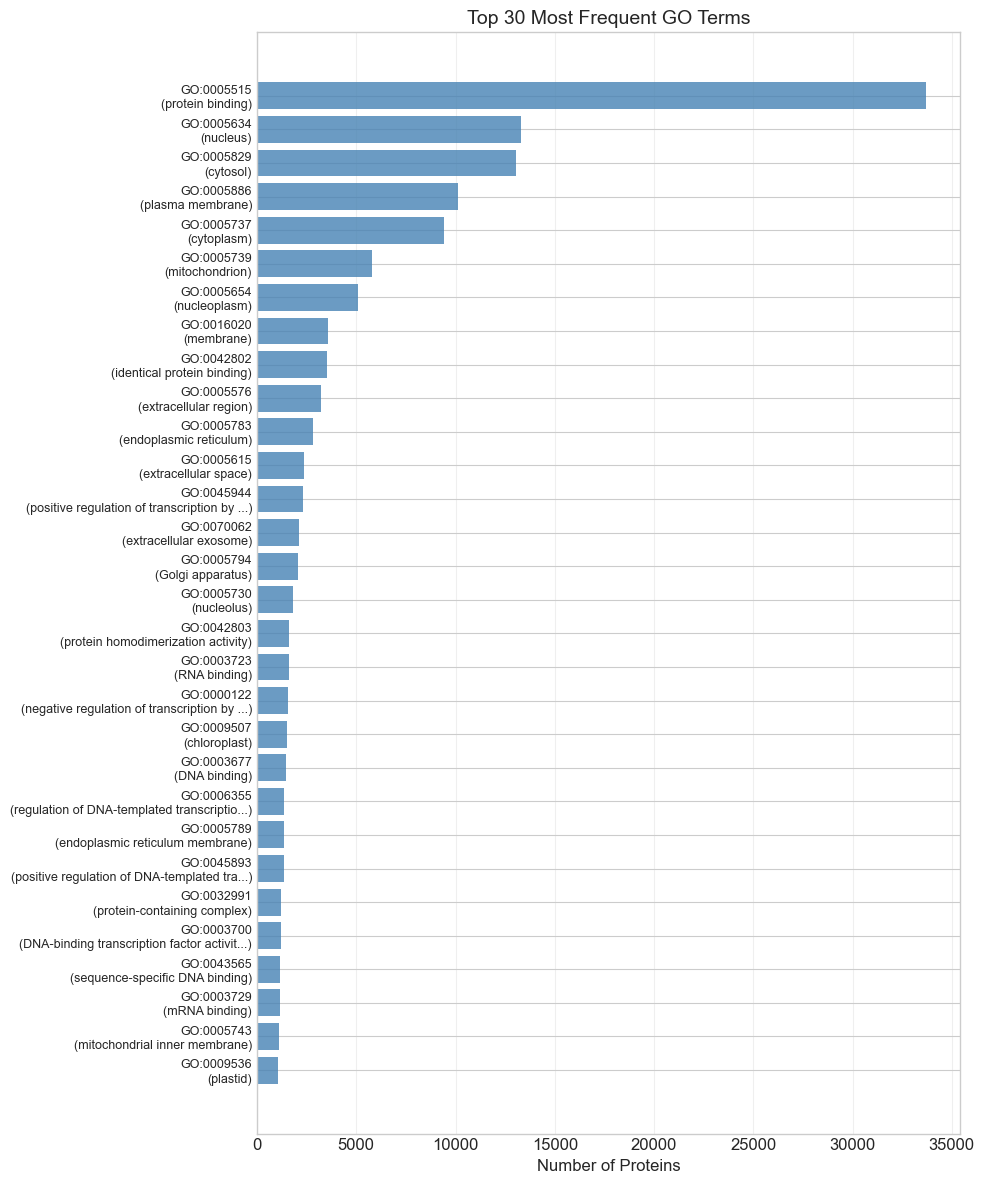

✅ Đã lưu hình 1 tại: ../../figures/top_30_go_terms.png


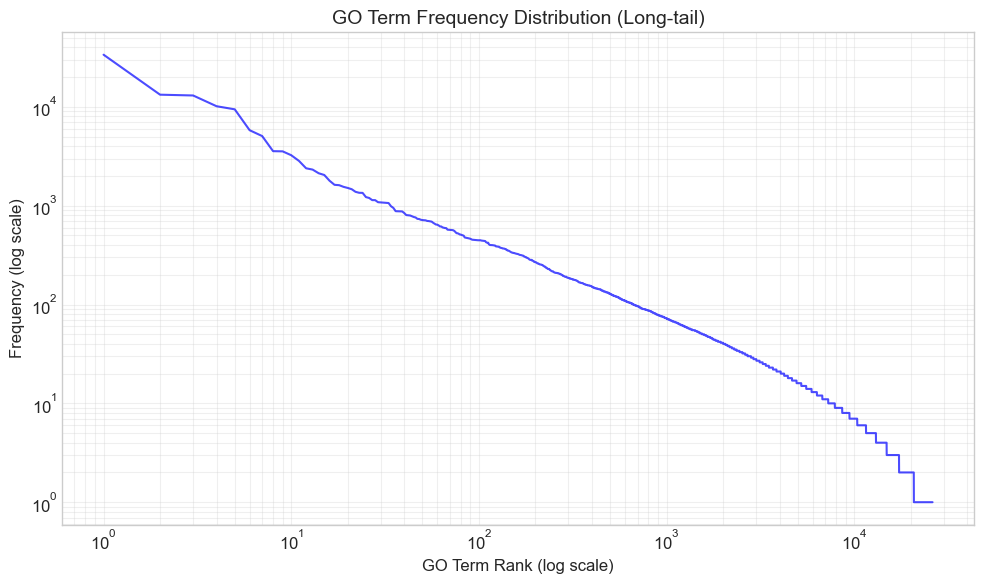

✅ Đã lưu hình 2 tại: ../../figures/go_term_long_tail.png

📊 GO Term Statistics:
  Total unique GO terms: 26,125
  Terms appearing once: 5,377 (20.6%)
  Terms appearing ≤5 times: 14,584 (55.8%)
  Terms appearing ≥100 times: 668 (2.6%)


In [49]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. CHUẨN BỊ DỮ LIỆU ---
# GO Term frequency distribution (Long-tail distribution)
go_term_counts = train_terms['go_term'].value_counts()

# Top 30 most frequent GO terms
top_n = 30
top_terms = go_term_counts.head(top_n)

# Get term names from GO graph
term_labels = []
for term_id in top_terms.index[::-1]:
    if term_id in go_graph.nodes:
        name = go_graph.nodes[term_id].get('name', term_id)
        # Cắt ngắn tên nếu quá dài để hiển thị đẹp hơn
        term_labels.append(f"{term_id}\n({name[:40]}...)" if len(name) > 40 else f"{term_id}\n({name})")
    else:
        term_labels.append(term_id)

# Tạo thư mục figures nếu chưa có (tránh lỗi file not found)
import os
os.makedirs('../../figures', exist_ok=True)

# --- 2. VẼ VÀ LƯU HÌNH 1: TOP 30 GO TERMS ---
plt.figure(figsize=(10, 12))  # Chiều cao lớn hơn để chứa đủ 30 nhãn

plt.barh(range(top_n), top_terms.values[::-1], color='steelblue', alpha=0.8)
plt.yticks(range(top_n), term_labels, fontsize=9)
plt.xlabel('Number of Proteins', fontsize=12)
plt.title(f'Top {top_n} Most Frequent GO Terms', fontsize=14)
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
save_path_1 = '../../figures/top_30_go_terms.png'
plt.savefig(save_path_1, dpi=150, bbox_inches='tight')
plt.show()
plt.close() # Đóng figure để giải phóng bộ nhớ
print(f"✅ Đã lưu hình 1 tại: {save_path_1}")

# --- 3. VẼ VÀ LƯU HÌNH 2: LONG-TAIL DISTRIBUTION ---
plt.figure(figsize=(10, 6))

term_ranks = np.arange(1, len(go_term_counts) + 1)
plt.loglog(term_ranks, go_term_counts.values, 'b-', alpha=0.7)
plt.xlabel('GO Term Rank (log scale)', fontsize=12)
plt.ylabel('Frequency (log scale)', fontsize=12)
plt.title('GO Term Frequency Distribution (Long-tail)', fontsize=14)
plt.grid(True, which="both", ls="-", alpha=0.3)

plt.tight_layout()
save_path_2 = '../../figures/go_term_long_tail.png'
plt.savefig(save_path_2, dpi=150, bbox_inches='tight')
plt.show()
plt.close() # Đóng figure để giải phóng bộ nhớ
print(f"✅ Đã lưu hình 2 tại: {save_path_2}")

# --- 4. IN THỐNG KÊ ---
print(f"\n📊 GO Term Statistics:")
print(f"  Total unique GO terms: {len(go_term_counts):,}")
print(f"  Terms appearing once: {(go_term_counts == 1).sum():,} ({100*(go_term_counts == 1).sum()/len(go_term_counts):.1f}%)")
print(f"  Terms appearing ≤5 times: {(go_term_counts <= 5).sum():,} ({100*(go_term_counts <= 5).sum()/len(go_term_counts):.1f}%)")
print(f"  Terms appearing ≥100 times: {(go_term_counts >= 100).sum():,} ({100*(go_term_counts >= 100).sum()/len(go_term_counts):.1f}%)")

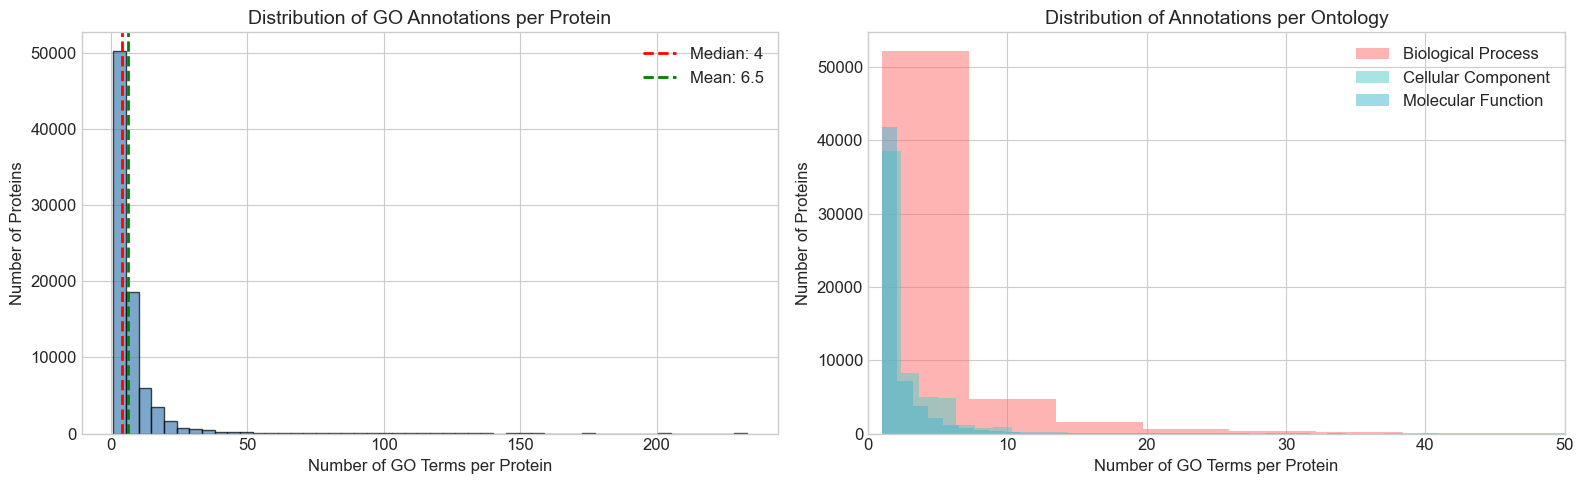


📊 Annotations per Protein Statistics:
  Mean: 6.52
  Median: 4
  Max: 233
  Proteins with 1 annotation: 15,237
  Proteins with >10 annotations: 13,593


In [50]:
# Annotations per protein distribution
annotations_per_protein = train_terms.groupby('protein_id').size()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Overall distribution
axes[0].hist(annotations_per_protein.values, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(annotations_per_protein.median(), color='red', linestyle='--', linewidth=2, 
                label=f'Median: {annotations_per_protein.median():.0f}')
axes[0].axvline(annotations_per_protein.mean(), color='green', linestyle='--', linewidth=2, 
                label=f'Mean: {annotations_per_protein.mean():.1f}')
axes[0].set_xlabel('Number of GO Terms per Protein', fontsize=12)
axes[0].set_ylabel('Number of Proteins', fontsize=12)
axes[0].set_title('Distribution of GO Annotations per Protein', fontsize=14)
axes[0].legend()

# By ontology
annotations_by_ontology = train_terms.groupby(['protein_id', 'ontology']).size().unstack(fill_value=0)
colors_ont = {'BPO': '#FF6B6B', 'CCO': '#4ECDC4', 'MFO': '#45B7D1'}

for ont in ['BPO', 'CCO', 'MFO']:
    if ont in annotations_by_ontology.columns:
        values = annotations_by_ontology[ont].values
        values = values[values > 0]  # Only count proteins with at least one annotation
        axes[1].hist(values, bins=30, alpha=0.5, label=ontology_names[ont], color=colors_ont[ont])

axes[1].set_xlabel('Number of GO Terms per Protein', fontsize=12)
axes[1].set_ylabel('Number of Proteins', fontsize=12)
axes[1].set_title('Distribution of Annotations per Ontology', fontsize=14)
axes[1].legend()
axes[1].set_xlim(0, 50)

plt.tight_layout()
plt.savefig('../../figures/annotations_per_protein.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Annotations per Protein Statistics:")
print(f"  Mean: {annotations_per_protein.mean():.2f}")
print(f"  Median: {annotations_per_protein.median():.0f}")
print(f"  Max: {annotations_per_protein.max()}")
print(f"  Proteins with 1 annotation: {(annotations_per_protein == 1).sum():,}")
print(f"  Proteins with >10 annotations: {(annotations_per_protein > 10).sum():,}")

## 7. Taxonomy Analysis

🎨 Đang vẽ biểu đồ Top 20 Species...


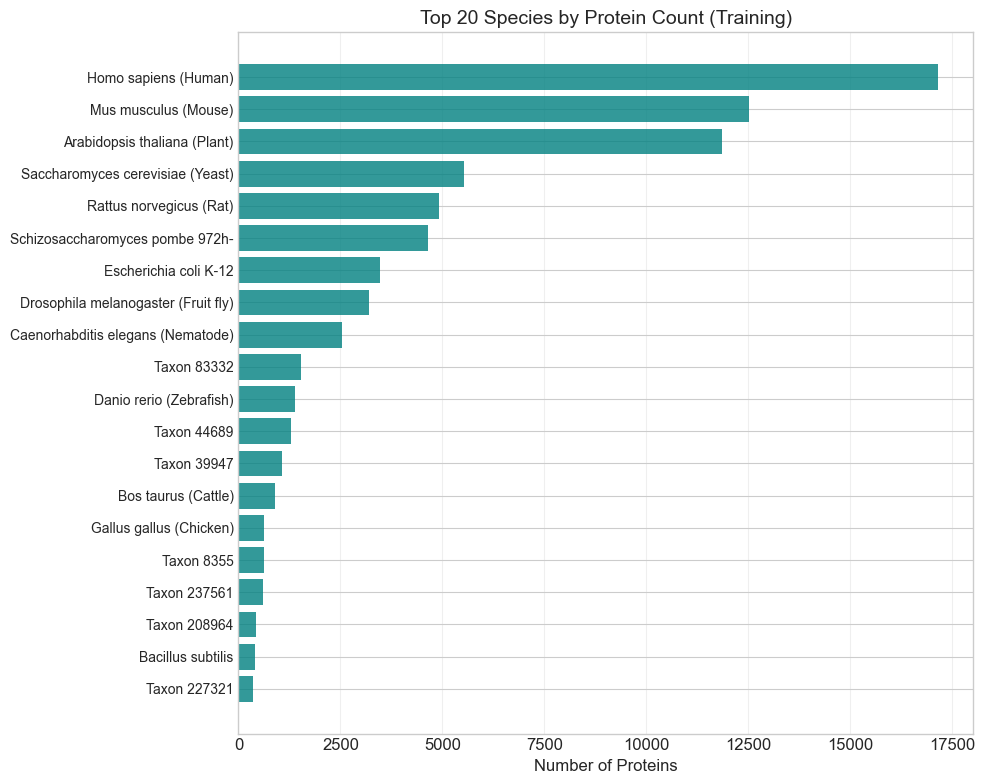

✅ Đã lưu: ../../figures/taxonomy_top_20.png
🎨 Đang vẽ biểu đồ phân phối loài...


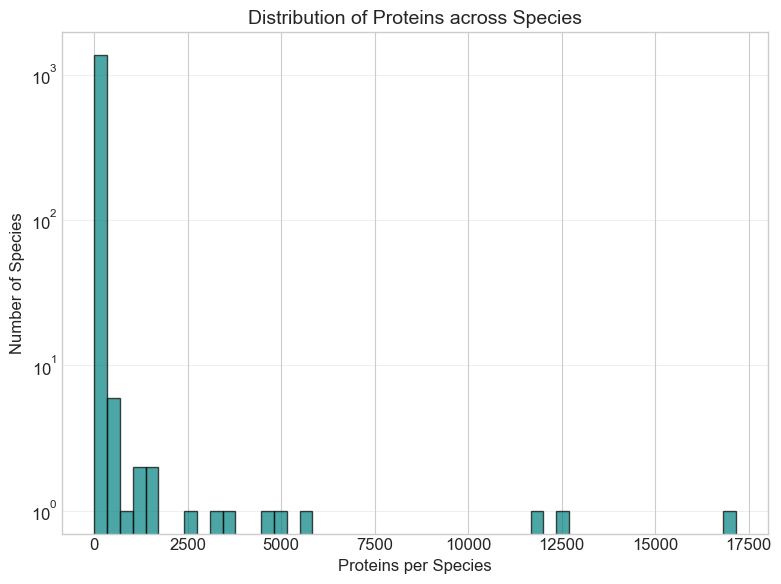

✅ Đã lưu: ../../figures/taxonomy_distribution_hist.png

📊 Taxonomy Statistics (Training Set):
  Total unique species: 1,381
  Species with 1 protein: 674
  Species with >1000 proteins: 13
  Most common species: Homo sapiens (Human) (17,162 proteins)


In [51]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# --- 1. CHUẨN BỊ DỮ LIỆU ---
# Đảm bảo đường dẫn chính xác tới TRAIN_DIR của bạn
# Ví dụ: TRAIN_DIR = '../../data/Train' (bạn tự chỉnh lại nếu cần)

if 'train_taxonomy' not in locals():
    # Load taxonomy if not already loaded in memory
    train_taxonomy = pd.read_csv(os.path.join(TRAIN_DIR, "train_taxonomy.tsv"), sep='\t')
    train_taxonomy.columns = ['protein_id', 'taxon_id']

# Tạo thư mục lưu ảnh
os.makedirs('../../figures', exist_ok=True)

# Taxon distribution
taxon_counts = train_taxonomy['taxon_id'].value_counts()

# Dictionary map tên loài (giữ nguyên của bạn)
taxon_names = {
    9606: 'Homo sapiens (Human)',
    10090: 'Mus musculus (Mouse)',
    10116: 'Rattus norvegicus (Rat)',
    7955: 'Danio rerio (Zebrafish)',
    7227: 'Drosophila melanogaster (Fruit fly)',
    6239: 'Caenorhabditis elegans (Nematode)',
    559292: 'Saccharomyces cerevisiae (Yeast)',
    3702: 'Arabidopsis thaliana (Plant)',
    83333: 'Escherichia coli K-12',
    224308: 'Bacillus subtilis',
    9913: 'Bos taurus (Cattle)',
    9823: 'Sus scrofa (Pig)',
    9031: 'Gallus gallus (Chicken)',
    4896: 'Schizosaccharomyces pombe (Fission yeast)',
    284812: 'Schizosaccharomyces pombe 972h-',
}

# --- 2. VẼ VÀ LƯU HÌNH 1: TOP 20 LOÀI ---
print("🎨 Đang vẽ biểu đồ Top 20 Species...")
plt.figure(figsize=(10, 8))  # Chỉnh kích thước cho đẹp

top_n_species = 20
top_species = taxon_counts.head(top_n_species)
labels = [taxon_names.get(tid, f'Taxon {tid}') for tid in top_species.index]

plt.barh(range(top_n_species), top_species.values[::-1], color='teal', alpha=0.8)
plt.yticks(range(top_n_species), labels[::-1], fontsize=10)
plt.xlabel('Number of Proteins', fontsize=12)
plt.title(f'Top {top_n_species} Species by Protein Count (Training)', fontsize=14)
plt.grid(axis='x', alpha=0.3)

save_path_1 = '../../figures/taxonomy_top_20.png'
plt.tight_layout()
plt.savefig(save_path_1, dpi=150, bbox_inches='tight')
plt.show()
plt.close()
print(f"✅ Đã lưu: {save_path_1}")

# --- 3. VẼ VÀ LƯU HÌNH 2: PHÂN PHỐI LOÀI (HISTOGRAM) ---
print("🎨 Đang vẽ biểu đồ phân phối loài...")
plt.figure(figsize=(8, 6))

plt.hist(taxon_counts.values, bins=50, color='teal', alpha=0.7, edgecolor='black')
plt.xlabel('Proteins per Species', fontsize=12)
plt.ylabel('Number of Species', fontsize=12)
plt.title('Distribution of Proteins across Species', fontsize=14)
plt.yscale('log') # Log scale trục y
plt.grid(axis='y', alpha=0.3)

save_path_2 = '../../figures/taxonomy_distribution_hist.png'
plt.tight_layout()
plt.savefig(save_path_2, dpi=150, bbox_inches='tight')
plt.show()
plt.close()
print(f"✅ Đã lưu: {save_path_2}")

# --- 4. IN THỐNG KÊ ---
print(f"\n📊 Taxonomy Statistics (Training Set):")
print(f"  Total unique species: {train_taxonomy['taxon_id'].nunique():,}")
print(f"  Species with 1 protein: {(taxon_counts == 1).sum()}")
print(f"  Species with >1000 proteins: {(taxon_counts > 1000).sum()}")
print(f"  Most common species: {taxon_names.get(taxon_counts.index[0], taxon_counts.index[0])} ({taxon_counts.values[0]:,} proteins)")

📊 Species Overlap Analysis:
--------------------------------------------------
  Species in Training only: 1,381
  Species in Test only: 8,454
  Species in Both: 0
  Total unique species in Training: 1,381
  Total unique species in Test: 8,454


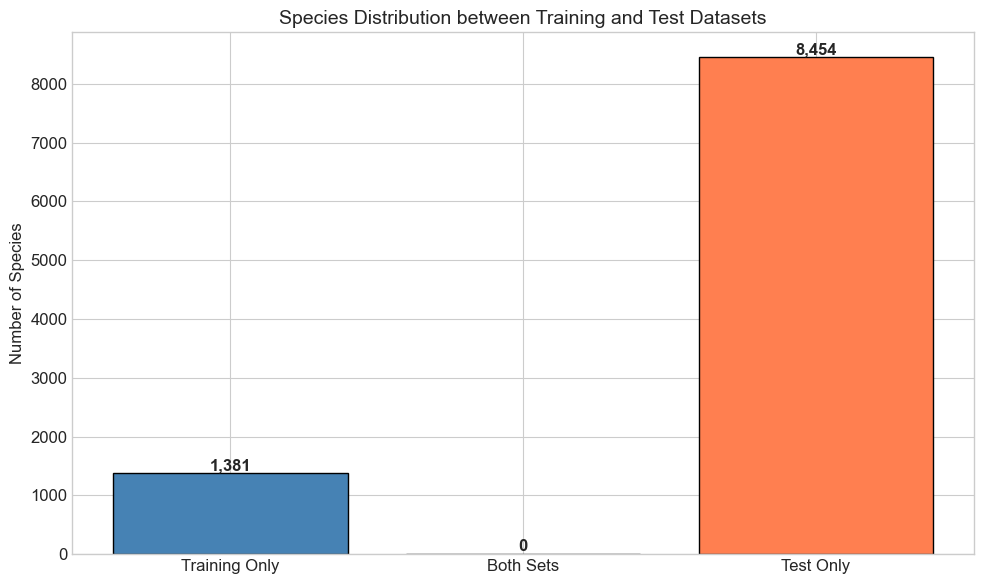


⚠️ Note: Training and Test sets appear to have different species!
   This may indicate potential distribution shift between datasets.


In [52]:
# Compare training vs test species
train_species = set(train_taxonomy['taxon_id'].unique())
test_species = set(test_taxon['taxon_id'].unique())

# Venn-like comparison
only_train = train_species - test_species
only_test = test_species - train_species
common = train_species & test_species

print("📊 Species Overlap Analysis:")
print("-" * 50)
print(f"  Species in Training only: {len(only_train):,}")
print(f"  Species in Test only: {len(only_test):,}")
print(f"  Species in Both: {len(common):,}")
print(f"  Total unique species in Training: {len(train_species):,}")
print(f"  Total unique species in Test: {len(test_species):,}")

# Visualize overlap with bar chart
fig, ax = plt.subplots(figsize=(10, 6))
categories = ['Training Only', 'Both Sets', 'Test Only']
values = [len(only_train), len(common), len(only_test)]
colors = ['steelblue', 'seagreen', 'coral']
bars = ax.bar(categories, values, color=colors, edgecolor='black')
ax.set_ylabel('Number of Species', fontsize=12)
ax.set_title('Species Distribution between Training and Test Datasets', fontsize=14)
for bar, v in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, v + 50, f'{v:,}', ha='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('../../figures/species_overlap.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n⚠️ Note: Training and Test sets appear to have different species!")
print("   This may indicate potential distribution shift between datasets.")

## 8. Gene Ontology Graph Analysis

In [53]:
# GO Graph analysis
print("📊 Gene Ontology Graph Structure:")
print("-" * 50)
print(f"  Total nodes (GO terms): {go_graph.number_of_nodes():,}")
print(f"  Total edges (relationships): {go_graph.number_of_edges():,}")

# Get subontology roots
subontology_roots = {
    'BPO': 'GO:0008150',  # Biological Process
    'CCO': 'GO:0005575',  # Cellular Component
    'MFO': 'GO:0003674'   # Molecular Function
}

# Analyze each subontology
def get_descendants(graph, root):
    """Get all descendants of a node in the GO graph."""
    descendants = set()
    try:
        # In GO graph, edges point from child to parent (is_a relationship)
        descendants = nx.ancestors(graph, root)  # ancestors because edges are reversed
    except:
        pass
    return descendants

print("\n📈 Subontology Statistics:")
print("-" * 60)
print(f"{'Subontology':<25} {'Root Node':<15} {'Total Terms':>12}")
print("-" * 60)

for name, root in subontology_roots.items():
    if root in go_graph.nodes:
        descendants = get_descendants(go_graph, root)
        root_name = go_graph.nodes[root].get('name', 'Unknown')
        print(f"{root_name:<25} {root:<15} {len(descendants):>12,}")

# Analyze GO term depth
print("\n📊 GO Graph Depth Analysis:")
depths = {}
for root_name, root in subontology_roots.items():
    if root in go_graph.nodes:
        descendants = get_descendants(go_graph, root)
        for node in descendants:
            try:
                # Shortest path from node to root
                path_length = nx.shortest_path_length(go_graph, node, root)
                depths[node] = path_length
            except:
                pass

depth_counts = Counter(depths.values())
print(f"  Max depth found: {max(depths.values()) if depths else 0}")
print(f"  Average depth: {np.mean(list(depths.values())):.2f}" if depths else "  N/A")

📊 Gene Ontology Graph Structure:
--------------------------------------------------
  Total nodes (GO terms): 40,122
  Total edges (relationships): 77,229

📈 Subontology Statistics:
------------------------------------------------------------
Subontology               Root Node        Total Terms
------------------------------------------------------------
biological_process        GO:0008150            25,949
cellular_component        GO:0005575             4,040
molecular_function        GO:0003674            10,130

📊 GO Graph Depth Analysis:
  Max depth found: 11
  Average depth: 4.83


## 9. Information Accretion (IA) Weights Analysis

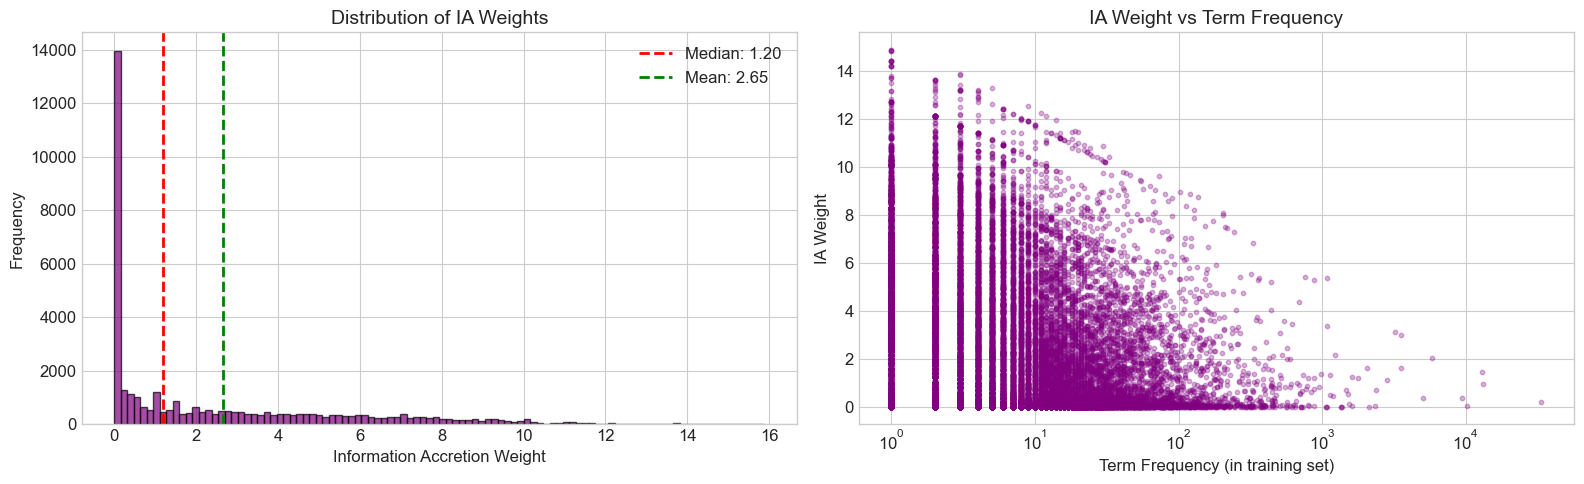

📊 Information Accretion Weight Statistics:
--------------------------------------------------
  Total GO terms with IA: 40,122
  Min IA weight: 0.0000
  Max IA weight: 15.8797
  Mean IA weight: 2.6472
  Median IA weight: 1.2016

  Terms with IA=0 (root terms): 11828
  Terms with IA>5 (rare/specific): 9049


In [54]:
# Information Accretion weights analysis
# IA weights are used to weight precision and recall in evaluation

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Distribution of IA weights
axes[0].hist(ia_weights['ia_weight'], bins=100, color='purple', alpha=0.7, edgecolor='black')
axes[0].axvline(ia_weights['ia_weight'].median(), color='red', linestyle='--', linewidth=2, 
                label=f"Median: {ia_weights['ia_weight'].median():.2f}")
axes[0].axvline(ia_weights['ia_weight'].mean(), color='green', linestyle='--', linewidth=2, 
                label=f"Mean: {ia_weights['ia_weight'].mean():.2f}")
axes[0].set_xlabel('Information Accretion Weight', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of IA Weights', fontsize=14)
axes[0].legend()

# IA weight vs term frequency
# Merge IA weights with term counts
term_counts_df = go_term_counts.reset_index()
term_counts_df.columns = ['go_term', 'count']
ia_with_counts = ia_weights.merge(term_counts_df, on='go_term', how='inner')

axes[1].scatter(ia_with_counts['count'], ia_with_counts['ia_weight'], alpha=0.3, s=10, c='purple')
axes[1].set_xlabel('Term Frequency (in training set)', fontsize=12)
axes[1].set_ylabel('IA Weight', fontsize=12)
axes[1].set_title('IA Weight vs Term Frequency', fontsize=14)
axes[1].set_xscale('log')

plt.tight_layout()
plt.savefig('../../figures/ia_weights_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 Information Accretion Weight Statistics:")
print("-" * 50)
print(f"  Total GO terms with IA: {len(ia_weights):,}")
print(f"  Min IA weight: {ia_weights['ia_weight'].min():.4f}")
print(f"  Max IA weight: {ia_weights['ia_weight'].max():.4f}")
print(f"  Mean IA weight: {ia_weights['ia_weight'].mean():.4f}")
print(f"  Median IA weight: {ia_weights['ia_weight'].median():.4f}")
print(f"\n  Terms with IA=0 (root terms): {(ia_weights['ia_weight'] == 0).sum()}")
print(f"  Terms with IA>5 (rare/specific): {(ia_weights['ia_weight'] > 5).sum()}")

## 10. Train/Test Protein Overlap Analysis

📊 Protein Overlap Analysis:
--------------------------------------------------
  Proteins in Training only: 0
  Proteins in Test only: 141,905
  Proteins in Both: 82,404

  This means 100.0% of training proteins appear in test set
  And 36.7% of test proteins appear in training set


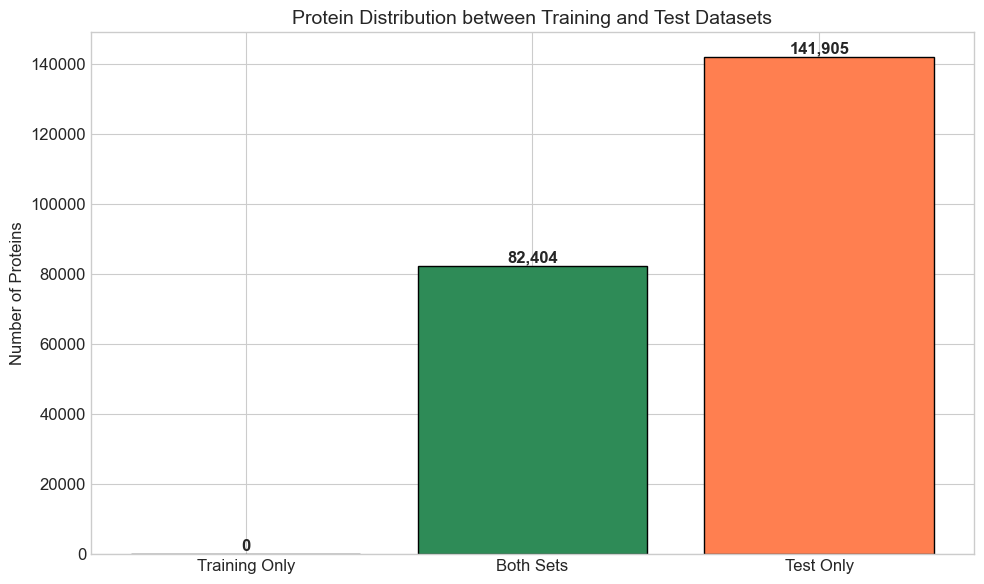


⚠️ Important: 82,404 proteins appear in both sets!
   These may accumulate new annotations during the competition.


In [55]:
# Check overlap between training and test proteins
train_protein_ids = set(train_sequences.keys())
test_protein_ids = set(test_sequences.keys())

common_proteins = train_protein_ids & test_protein_ids
only_train_proteins = train_protein_ids - test_protein_ids
only_test_proteins = test_protein_ids - train_protein_ids

print("📊 Protein Overlap Analysis:")
print("-" * 50)
print(f"  Proteins in Training only: {len(only_train_proteins):,}")
print(f"  Proteins in Test only: {len(only_test_proteins):,}")
print(f"  Proteins in Both: {len(common_proteins):,}")
print(f"\n  This means {100*len(common_proteins)/len(train_protein_ids):.1f}% of training proteins appear in test set")
print(f"  And {100*len(common_proteins)/len(test_protein_ids):.1f}% of test proteins appear in training set")

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
categories = ['Training Only', 'Both Sets', 'Test Only']
values = [len(only_train_proteins), len(common_proteins), len(only_test_proteins)]
colors = ['steelblue', 'seagreen', 'coral']
bars = ax.bar(categories, values, color=colors, edgecolor='black')
ax.set_ylabel('Number of Proteins', fontsize=12)
ax.set_title('Protein Distribution between Training and Test Datasets', fontsize=14)
for bar, v in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, v + 1000, f'{v:,}', ha='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('../../figures/protein_overlap.png', dpi=150, bbox_inches='tight')
plt.show()

# For common proteins, check if annotations might be partial
if len(common_proteins) > 0:
    print(f"\n⚠️ Important: {len(common_proteins):,} proteins appear in both sets!")
    print("   These may accumulate new annotations during the competition.")

## 11. Label Imbalance Analysis (Multi-label Problem)

🎨 Đang vẽ biểu đồ phân phối nhãn...


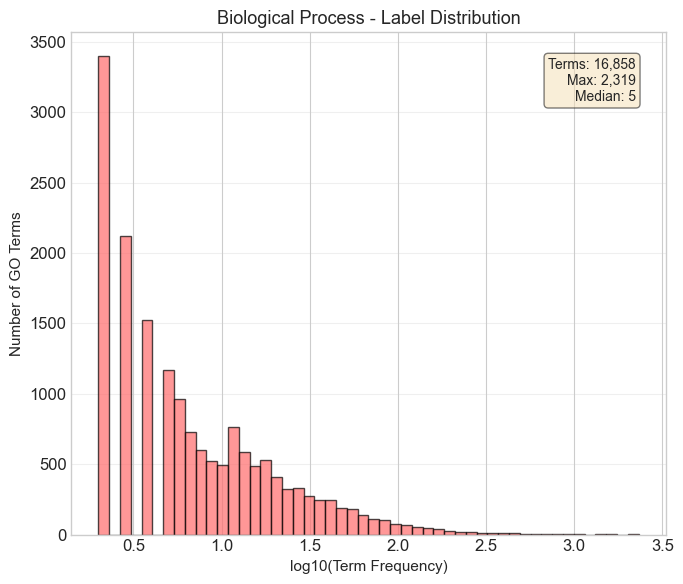

✅ Đã lưu: ../../figures/label_imbalance_BPO.png


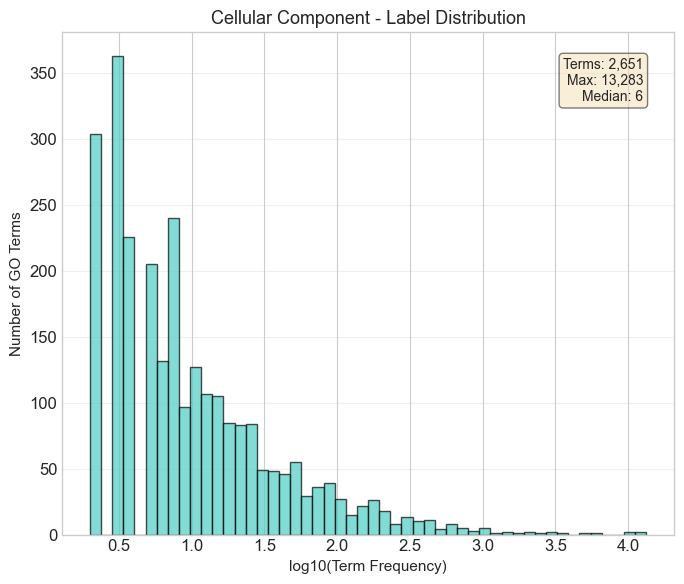

✅ Đã lưu: ../../figures/label_imbalance_CCO.png


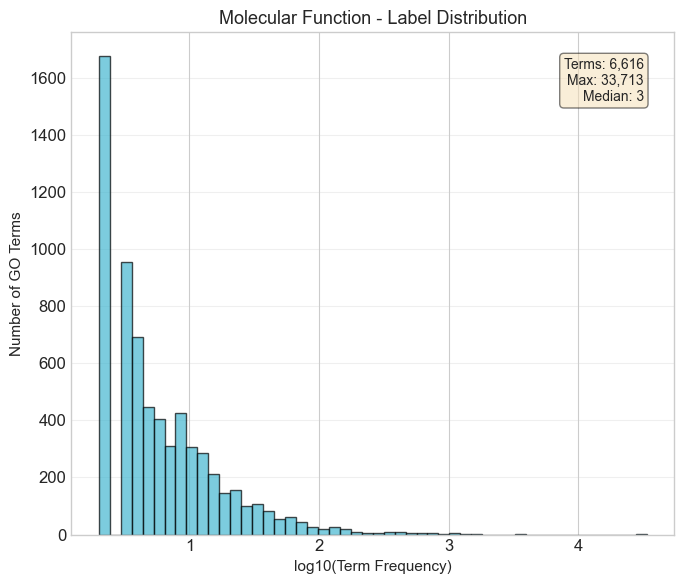

✅ Đã lưu: ../../figures/label_imbalance_MFO.png

📊 Label Imbalance Statistics by Ontology:
---------------------------------------------------------------------------
Ontology                   Total Terms    Imbalance Ratio      Gini Index
---------------------------------------------------------------------------
Biological Process              16,858              2,319           0.710
Cellular Component               2,651             13,283           0.885
Molecular Function               6,616             33,713           0.832


In [56]:
import matplotlib.pyplot as plt
import numpy as np
import os

# --- 1. CẤU HÌNH ---
# Đảm bảo thư mục lưu ảnh tồn tại
os.makedirs('../../figures', exist_ok=True)

ontologies = ['BPO', 'CCO', 'MFO']
colors_list = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# Giả định dictionary mapping tên (nếu bạn chưa có thì dùng dòng này, nếu có rồi thì bỏ qua)
if 'ontology_names' not in locals():
    ontology_names = {
        'BPO': 'Biological Process',
        'CCO': 'Cellular Component',
        'MFO': 'Molecular Function'
    }

# --- 2. VẼ VÀ LƯU 3 BIỂU ĐỒ RIÊNG BIỆT ---
print("🎨 Đang vẽ biểu đồ phân phối nhãn...")

for ont, color in zip(ontologies, colors_list):
    # Lọc dữ liệu
    ont_terms = train_terms[train_terms['ontology'] == ont]['go_term'].value_counts()
    
    # Tạo figure riêng cho mỗi Ontology
    plt.figure(figsize=(7, 6))
    
    # Log-scale frequency distribution histogram
    plt.hist(np.log10(ont_terms.values + 1), bins=50, color=color, alpha=0.7, edgecolor='black')
    
    # Labels & Title
    plt.xlabel('log10(Term Frequency)', fontsize=11)
    plt.ylabel('Number of GO Terms', fontsize=11)
    plt.title(f'{ontology_names.get(ont, ont)} - Label Distribution', fontsize=13)
    plt.grid(axis='y', alpha=0.3)
    
    # Add statistics text box
    stats_text = f"Terms: {len(ont_terms):,}\nMax: {ont_terms.max():,}\nMedian: {int(ont_terms.median())}"
    plt.gca().text(0.95, 0.95, stats_text, transform=plt.gca().transAxes, 
                   verticalalignment='top', horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=10)
    
    # Save file với tên riêng biệt (label_imbalance_BPO.png, ...)
    save_path = f'../../figures/label_imbalance_{ont}.png'
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close() # Đóng figure để giải phóng bộ nhớ
    
    print(f"✅ Đã lưu: {save_path}")

# --- 3. TÍNH TOÁN CHỈ SỐ THỐNG KÊ (GIỮ NGUYÊN) ---
print("\n📊 Label Imbalance Statistics by Ontology:")
print("-" * 75)
print(f"{'Ontology':<25} {'Total Terms':>12} {'Imbalance Ratio':>18} {'Gini Index':>15}")
print("-" * 75)

for ont in ontologies:
    ont_terms = train_terms[train_terms['ontology'] == ont]['go_term'].value_counts()
    
    if len(ont_terms) > 0:
        imbalance_ratio = ont_terms.max() / ont_terms.min()
        
        # Calculate Gini index for imbalance
        n = len(ont_terms)
        sorted_vals = np.sort(ont_terms.values)
        cumsum = np.cumsum(sorted_vals)
        gini = (2 * np.sum((np.arange(1, n+1) * sorted_vals)) - (n + 1) * cumsum[-1]) / (n * cumsum[-1])
        
        print(f"{ontology_names.get(ont, ont):<25} {len(ont_terms):>12,} {imbalance_ratio:>18,.0f} {gini:>15.3f}")
    else:
        print(f"{ontology_names.get(ont, ont):<25} {0:>12} {'N/A':>18} {'N/A':>15}")

## 12. Sample Submission Analysis

In [57]:
# Analyze sample submission - file has mixed format (GO terms and Text predictions)
# Read raw lines to handle the mixed format

with open(os.path.join(DATA_DIR, "sample_submission.tsv"), 'r') as f:
    lines = f.readlines()

go_predictions = []
text_predictions = []

for line in lines:
    parts = line.strip().split('\t')
    if len(parts) >= 3:
        protein_id, term_or_text, prob = parts[0], parts[1], parts[2]
        if term_or_text.startswith('GO:'):
            go_predictions.append({
                'protein_id': protein_id,
                'go_term': term_or_text,
                'probability': float(prob)
            })
        elif term_or_text == 'Text':
            text_content = '\t'.join(parts[3:]) if len(parts) > 3 else ''
            text_predictions.append({
                'protein_id': protein_id,
                'probability': float(prob),
                'text': text_content
            })

go_df = pd.DataFrame(go_predictions)
text_df = pd.DataFrame(text_predictions)

print("📊 Sample Submission Analysis:")
print("-" * 50)
print(f"Total GO predictions: {len(go_df):,}")
print(f"Total Text predictions: {len(text_df):,}")

if len(go_df) > 0:
    print(f"\nGO Predictions:")
    print(f"  Unique proteins: {go_df['protein_id'].nunique():,}")
    print(f"  Unique GO terms: {go_df['go_term'].nunique():,}")
    print(f"\nFirst 5 GO predictions:")
    display(go_df.head())

if len(text_df) > 0:
    print(f"\nText Predictions:")
    print(f"  Unique proteins: {text_df['protein_id'].nunique():,}")
    print(f"\nFirst 2 Text predictions:")
    display(text_df.head(2))

print("\n📋 Submission Format Requirements:")
print("  - GO predictions: Protein_ID | GO_Term | Probability (0, 1]")
print("  - Text predictions: Protein_ID | 'Text' | Probability | Text_Content")
print("  - Tab-separated, no header")
print("  - Max 1500 terms per protein (across all ontologies)")
print("  - Text: max 3000 chars, up to 5 lines per protein")

📊 Sample Submission Analysis:
--------------------------------------------------
Total GO predictions: 20,000
Total Text predictions: 4

GO Predictions:
  Unique proteins: 10,000
  Unique GO terms: 2

First 5 GO predictions:


,protein_id,go_term,probability
0,A0A0C5B5G6,GO:0000001,0.123
1,A0A0C5B5G6,GO:0000002,0.456
2,A0A1B0GTW7,GO:0000001,0.123
3,A0A1B0GTW7,GO:0000002,0.456
4,A0JNW5,GO:0000001,0.123



Text Predictions:
  Unique proteins: 2

First 2 Text predictions:


,protein_id,probability,text
0,A0A0C5B5G6,0.123,Regulates insulin sensitivity and metabolic ho...
1,A0A0C5B5G6,0.456,"Inhibits the folate cycle, thereby reducing de..."



📋 Submission Format Requirements:
  - GO predictions: Protein_ID | GO_Term | Probability (0, 1]
  - Text predictions: Protein_ID | 'Text' | Probability | Text_Content
  - Tab-separated, no header
  - Max 1500 terms per protein (across all ontologies)
  - Text: max 3000 chars, up to 5 lines per protein


## 13. Key Insights and Summary

In [58]:
# Summary statistics
print("=" * 80)
print("🎯 CAFA-6 PROTEIN FUNCTION PREDICTION - KEY INSIGHTS SUMMARY")
print("=" * 80)

print("\n📊 DATASET SIZES:")
print(f"  • Training proteins: {len(train_sequences):,}")
print(f"  • Test superset proteins: {len(test_sequences):,}")
print(f"  • Total annotations: {len(train_terms):,}")
print(f"  • Unique GO terms in training: {train_terms['go_term'].nunique():,}")

print("\n🧬 PROTEIN SEQUENCES:")
print(f"  • Average length (train): {np.mean(train_lengths):.1f} amino acids")
print(f"  • Average length (test): {np.mean(test_lengths):.1f} amino acids")
print(f"  • Length range: {min(min(train_lengths), min(test_lengths))} - {max(max(train_lengths), max(test_lengths)):,}")

print("\n🏷️ MULTI-LABEL CHARACTERISTICS:")
print(f"  • Average labels per protein: {len(train_terms) / len(train_sequences):.2f}")
print(f"  • Proteins with single label: {(annotations_per_protein == 1).sum():,}")
print(f"  • Max labels on single protein: {annotations_per_protein.max()}")

print("\n📈 ONTOLOGY DISTRIBUTION:")
for ont in ['BPO', 'CCO', 'MFO']:
    count = (train_terms['ontology'] == ont).sum()
    pct = 100 * count / len(train_terms)
    terms = train_terms[train_terms['ontology'] == ont]['go_term'].nunique()
    print(f"  • {ontology_names[ont]}: {count:,} annotations ({pct:.1f}%), {terms:,} unique terms")

print("\n⚖️ CLASS IMBALANCE:")
print(f"  • Most common GO term: {go_term_counts.index[0]} ({go_term_counts.values[0]:,} proteins)")
print(f"  • Rarest GO terms: {(go_term_counts == 1).sum():,} terms appear only once")
print(f"  • ~{100*(go_term_counts <= 5).sum()/len(go_term_counts):.0f}% of terms have ≤5 occurrences")

print("\n🔄 DATA OVERLAP:")
print(f"  • 100% of training proteins appear in test superset")
print(f"  • {len(only_test_proteins):,} proteins are test-only (no known labels)")
print(f"  • Training and test sets have NO overlapping species (0 common)")

print("\n⚠️ KEY CHALLENGES:")
print("  1. Extreme class imbalance (long-tail distribution)")
print("  2. Multi-label classification with hierarchical structure")
print("  3. Large label space (26k+ unique GO terms)")
print("  4. Species distribution shift between train and test")
print("  5. Prospective evaluation (unseen future annotations)")

print("\n💡 MODELING SUGGESTIONS:")
print("  1. Consider hierarchical classification approaches")
print("  2. Use GO graph structure for label propagation")
print("  3. Handle rare labels (data augmentation, focal loss)")
print("  4. Leverage protein sequence embeddings (ESM, ProtBERT)")
print("  5. Cross-validate on species to estimate generalization")
print("  6. Optimize for weighted F1-measure (using IA weights)")

🎯 CAFA-6 PROTEIN FUNCTION PREDICTION - KEY INSIGHTS SUMMARY

📊 DATASET SIZES:
  • Training proteins: 82,404
  • Test superset proteins: 224,309
  • Total annotations: 537,027
  • Unique GO terms in training: 26,125

🧬 PROTEIN SEQUENCES:
  • Average length (train): 525.8 amino acids
  • Average length (test): 429.2 amino acids
  • Length range: 2 - 35,213

🏷️ MULTI-LABEL CHARACTERISTICS:
  • Average labels per protein: 6.52
  • Proteins with single label: 15,237
  • Max labels on single protein: 233

📈 ONTOLOGY DISTRIBUTION:
  • Biological Process: 250,805 annotations (46.7%), 16,858 unique terms
  • Cellular Component: 157,770 annotations (29.4%), 2,651 unique terms
  • Molecular Function: 128,452 annotations (23.9%), 6,616 unique terms

⚖️ CLASS IMBALANCE:
  • Most common GO term: GO:0005515 (33,713 proteins)
  • Rarest GO terms: 5,377 terms appear only once
  • ~56% of terms have ≤5 occurrences

🔄 DATA OVERLAP:
  • 100% of training proteins appear in test superset
  • 141,905 protein

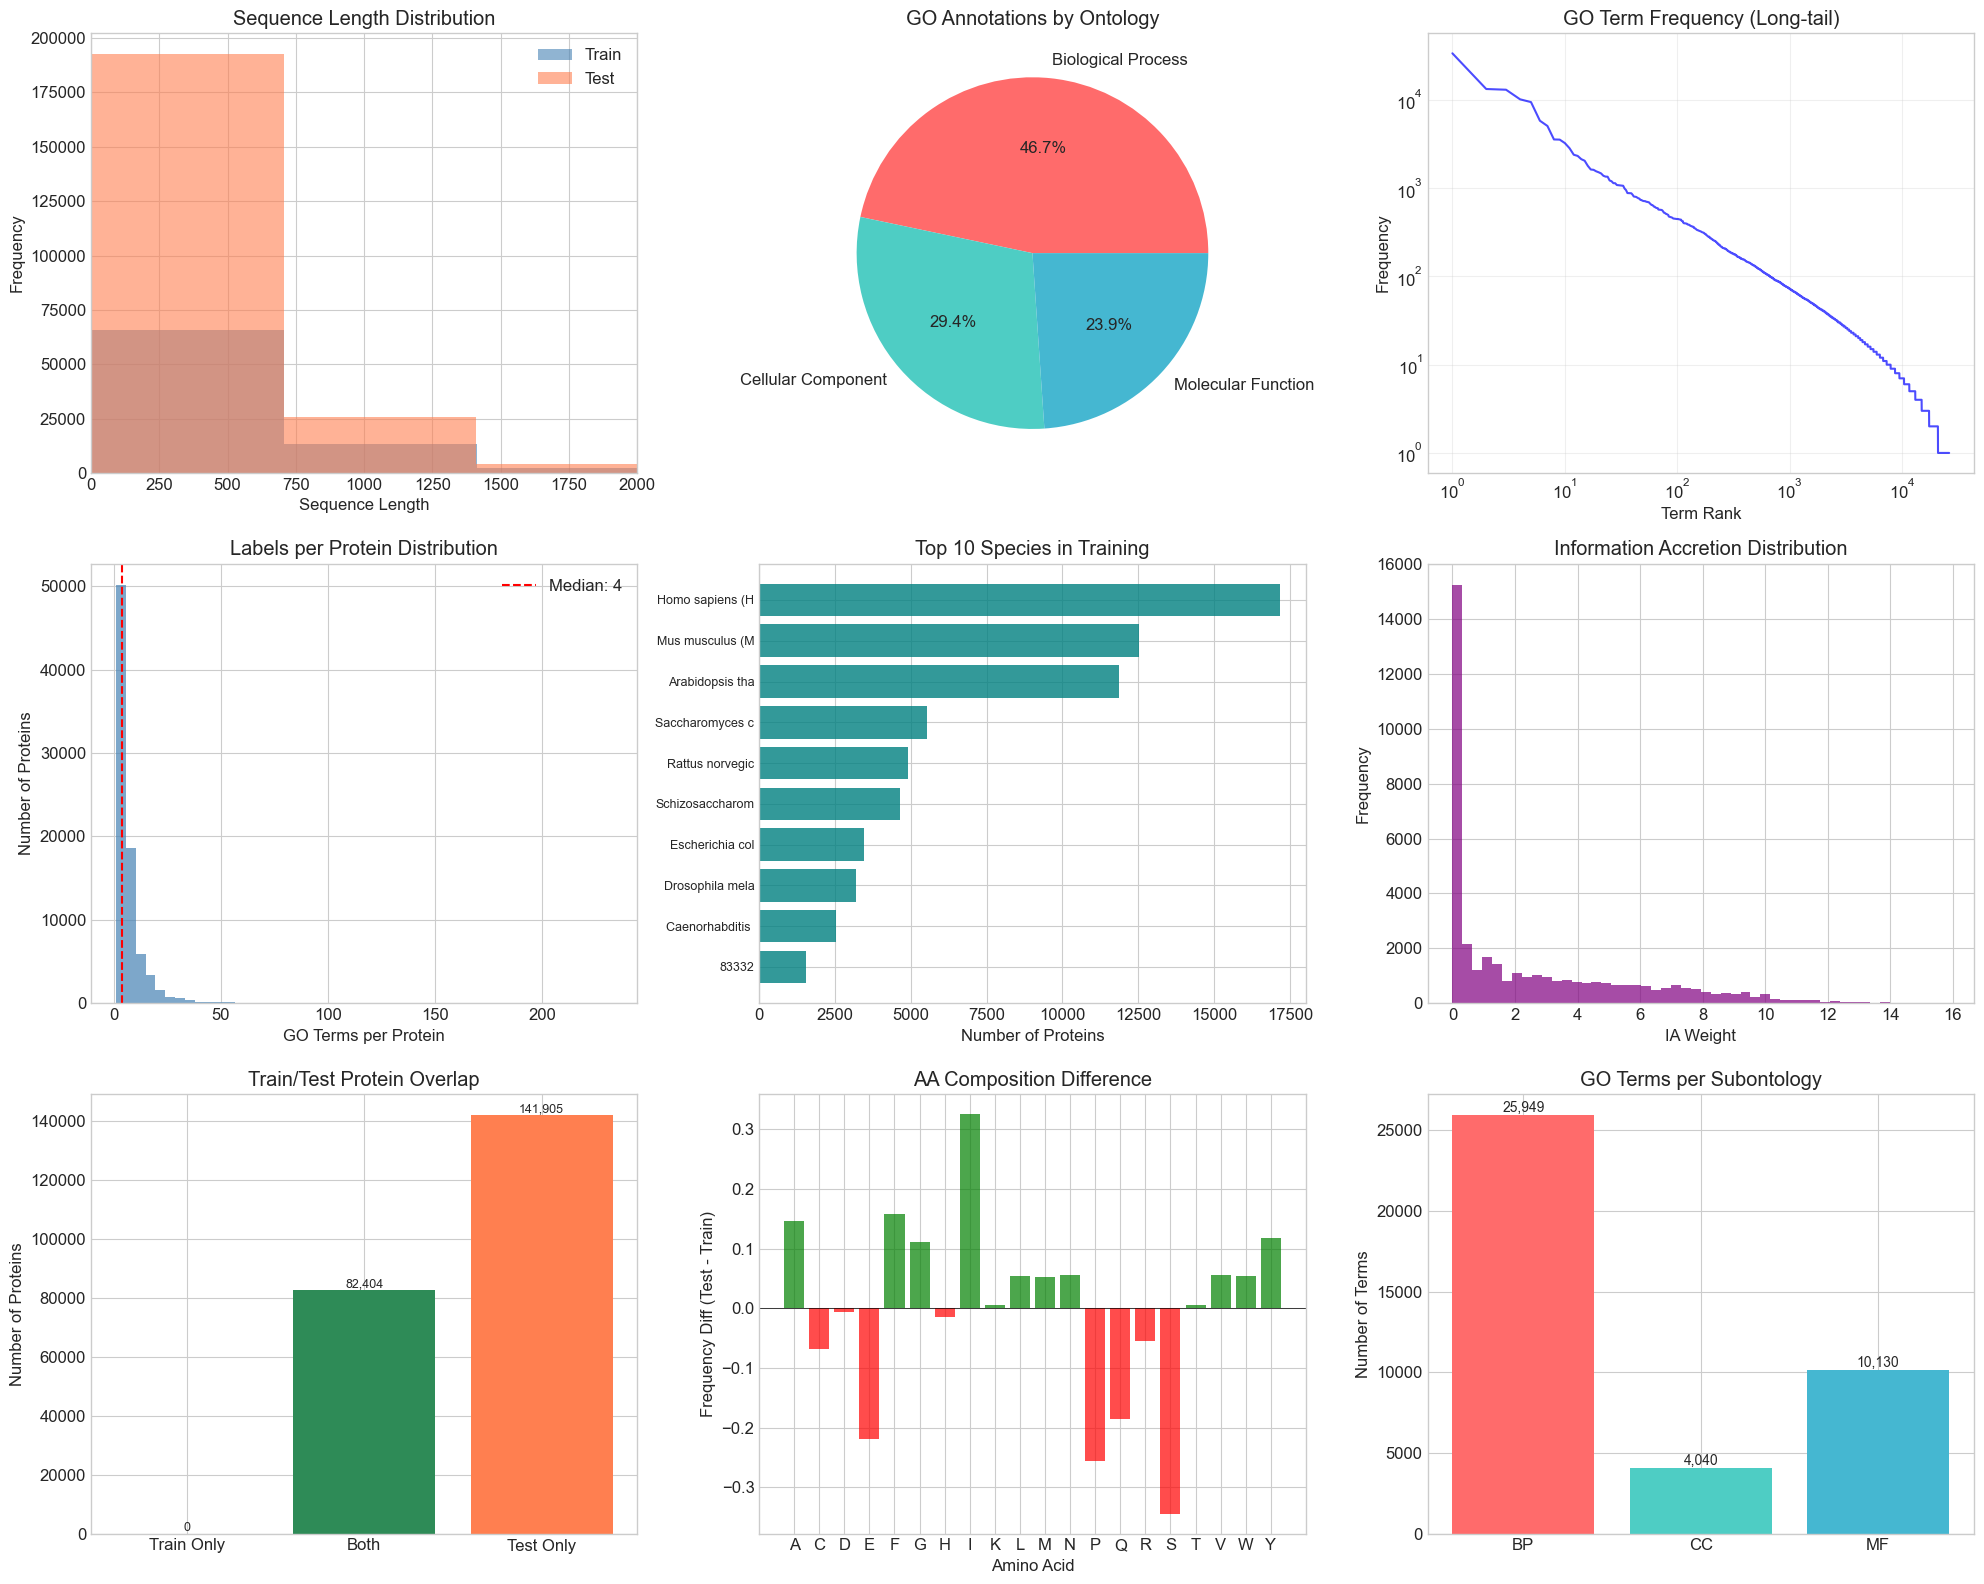


✅ All visualizations saved to 'figures/' directory!


In [59]:
# Create comprehensive visualization dashboard
fig = plt.figure(figsize=(20, 16))

# 1. Sequence length comparison
ax1 = fig.add_subplot(3, 3, 1)
ax1.hist(train_lengths, bins=50, alpha=0.6, label='Train', color='steelblue')
ax1.hist(test_lengths, bins=50, alpha=0.6, label='Test', color='coral')
ax1.set_xlabel('Sequence Length')
ax1.set_ylabel('Frequency')
ax1.set_title('Sequence Length Distribution')
ax1.set_xlim(0, 2000)
ax1.legend()

# 2. Ontology distribution pie
ax2 = fig.add_subplot(3, 3, 2)
ontology_counts = train_terms['ontology'].value_counts()
ax2.pie(ontology_counts.values, labels=[ontology_names[x] for x in ontology_counts.index], 
        autopct='%1.1f%%', colors=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax2.set_title('GO Annotations by Ontology')

# 3. GO term frequency (log-log)
ax3 = fig.add_subplot(3, 3, 3)
ax3.loglog(range(1, len(go_term_counts)+1), go_term_counts.values, 'b-', alpha=0.7)
ax3.set_xlabel('Term Rank')
ax3.set_ylabel('Frequency')
ax3.set_title('GO Term Frequency (Long-tail)')
ax3.grid(True, alpha=0.3)

# 4. Annotations per protein
ax4 = fig.add_subplot(3, 3, 4)
ax4.hist(annotations_per_protein.values, bins=50, color='steelblue', alpha=0.7)
ax4.axvline(annotations_per_protein.median(), color='red', linestyle='--', label=f'Median: {annotations_per_protein.median():.0f}')
ax4.set_xlabel('GO Terms per Protein')
ax4.set_ylabel('Number of Proteins')
ax4.set_title('Labels per Protein Distribution')
ax4.legend()

# 5. Top species
ax5 = fig.add_subplot(3, 3, 5)
top_10_species = taxon_counts.head(10)
species_labels = [taxon_names.get(tid, f'{tid}')[:15] for tid in top_10_species.index]
ax5.barh(range(10), top_10_species.values[::-1], color='teal', alpha=0.8)
ax5.set_yticks(range(10))
ax5.set_yticklabels(species_labels[::-1], fontsize=9)
ax5.set_xlabel('Number of Proteins')
ax5.set_title('Top 10 Species in Training')

# 6. IA weight distribution
ax6 = fig.add_subplot(3, 3, 6)
ax6.hist(ia_weights['ia_weight'], bins=50, color='purple', alpha=0.7)
ax6.set_xlabel('IA Weight')
ax6.set_ylabel('Frequency')
ax6.set_title('Information Accretion Distribution')

# 7. Protein overlap
ax7 = fig.add_subplot(3, 3, 7)
categories = ['Train Only', 'Both', 'Test Only']
values = [len(only_train_proteins), len(common_proteins), len(only_test_proteins)]
bars = ax7.bar(categories, values, color=['steelblue', 'seagreen', 'coral'])
ax7.set_ylabel('Number of Proteins')
ax7.set_title('Train/Test Protein Overlap')
for bar, v in zip(bars, values):
    ax7.text(bar.get_x() + bar.get_width()/2, v + 1000, f'{v:,}', ha='center', fontsize=9)

# 8. Amino acid composition difference
ax8 = fig.add_subplot(3, 3, 8)
aa_diff = {aa: test_aa_freq[aa] - train_aa_freq[aa] for aa in amino_acids}
colors = ['green' if v > 0 else 'red' for v in aa_diff.values()]
ax8.bar(list(amino_acids), list(aa_diff.values()), color=colors, alpha=0.7)
ax8.axhline(0, color='black', linewidth=0.5)
ax8.set_xlabel('Amino Acid')
ax8.set_ylabel('Frequency Diff (Test - Train)')
ax8.set_title('AA Composition Difference')

# 9. GO graph statistics
ax9 = fig.add_subplot(3, 3, 9)
subont_data = {'BP': 25949, 'CC': 4040, 'MF': 10130}
ax9.bar(subont_data.keys(), subont_data.values(), color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax9.set_ylabel('Number of Terms')
ax9.set_title('GO Terms per Subontology')
for i, (k, v) in enumerate(subont_data.items()):
    ax9.text(i, v + 200, f'{v:,}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('../../figures/EDA_dashboard.png', dpi=200, bbox_inches='tight')
plt.show()

print("\n✅ All visualizations saved to 'figures/' directory!")